In [1]:
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


plt.rcParams['animation.writer'] = 'avconv'
%matplotlib inline

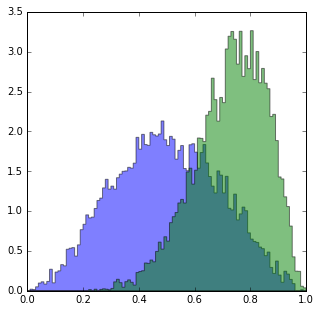

In [2]:
s_raw = np.random.beta(8,3, 8000)
b_raw = np.random.beta(3,3, 8000)

weight =np.concatenate((np.random.binomial(10,0.5, 8000)/100.0,np.random.binomial(10,0.5, 8000)/1.0))
y =np.concatenate((np.ones(s_raw.shape[0]),np.zeros(b_raw.shape[0])))

data = np.concatenate((s_raw,b_raw))

fig = plt.figure(figsize=(5,5))
bb,_,_ = plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5, normed=True)
ss,_,_ = plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5, normed=True)
# plt.yscale('log')
plt.show()

In [3]:
from tools import kde
from scipy.integrate import quad

100
100
(0.9991335307663743, 8.95754358615027e-10)
(0.9994741286099476, 6.864138889025584e-09)


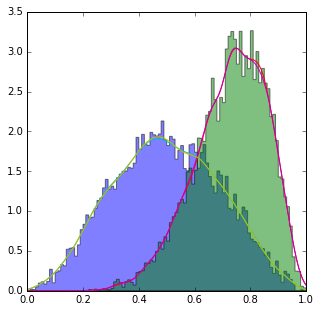

In [4]:

pdf_s = kde.gaussian_kde(data[y==1])
pdf_b = kde.gaussian_kde(data[y==0])

x  = np.linspace(0,1, 200)
pss = pdf_s(x)
pbb = pdf_b(x)

print len(ss)
print len(bb)

fig = plt.figure(figsize=(5,5))
bb,_,_ = plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5, normed=True)
ss,_,_ = plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5, normed=True)

plt.plot(x, pss, label='kde-s')
plt.plot(x, pbb, label='kde-b')

plt.plot(x, kde.gaussian_kde(data[y==1], weights=weight[y==1])(x), label='kde-s')
plt.plot(x, kde.gaussian_kde(data[y==0], weights=weight[y==0])(x), label='kde-b')


ss_fun = lambda x : pdf_s(x)
bb_fun = lambda x : pdf_b(x)

print quad(ss_fun, 0, 1)
print quad(bb_fun, 0, 1)
print pdf_s
# plt.yscale('log')
plt.show()

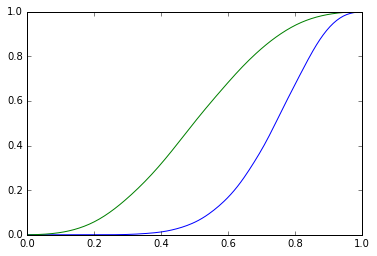

In [5]:
s_ = kde.gaussian_kde(data[y==1], weights=weight[y==1])
b_ = kde.gaussian_kde(data[y==0], weights=weight[y==0])

plt.plot(x, [s_.integrate_box_1d(0,x[i]) for i in range(x.shape[0])], label='kde-s')
plt.plot(x, [b_.integrate_box_1d(0,x[i]) for i in range(x.shape[0])], label='kde-b')

In [6]:
from scipy import optimize
from scipy.integrate import quad

class binner_base(object):
    """ Abstract class for classification based binning
    """
    def __init__(self, nbins, range):
        self.nbins = nbins
        self.range = range
        raise NotImplementedError('Method or function has not been implemented yet')
    def fit(self, X, y, sample_weights=None):
        raise NotImplementedError('Method or function has not been implemented yet')
        return self
    
class costum_bounds(object):
    def __init__(self, xmax=[1.1,1.1], xmin=[-1.1,-1.1] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin
    
class zbinner(binner_base):
    def __init__(self,nbins, range, drop_last_bin=True, 
                 fix_upper=True, fix_lower=False, use_kde_density = True):
        self.nbins = nbins
        self.range = range
        self.drop_last_bin = drop_last_bin
        self.X = None
        self.y = None
        self.pdf_s = None
        self.pdf_b = None
        self.fix_upper = fix_upper
        self.fix_lower = fix_lower
        self.breg = 0
        self.use_kde_density = use_kde_density
        self.sample_weights = None
        self.scan = {"bounds": [],"cost": []}
        
    def _fom_(self,s,b,breg=10):
        c = np.zeros(s.shape[0])
        c[(s == 0) & (b==0)] = 0
        c[(s+b)!=0] = s[(s+b)!=0] / np.sqrt((s+b+breg)[(s+b)!=0])
        return c
    def binned_score(self,x):
        x = np.sort(x)
        nb_,_  = np.histogram(self.X[self.y==0],bins=x, range=self.range, weights=self.sample_weights[self.y==0])
        ns_,_  = np.histogram(self.X[self.y==1],bins=x, range=self.range, weights=self.sample_weights[self.y==1])
        if nb_.shape !=  ns_.shape :    
            return 0
        else:
            return self._fom_(ns_, nb_)
    def binned_score_density(self,x):
        x = np.sort(x)
        ns_= self.sample_weights[self.y==1].sum()*np.array([self.pdf_s.integrate_box_1d(x[i], x[i+1]) for i in range(x.shape[0]-1)])
        nb_= self.sample_weights[self.y==0].sum()*np.array([self.pdf_b.integrate_box_1d(x[i], x[i+1]) for i in range(x.shape[0]-1)])
        if nb_.shape !=  ns_.shape :    
            return 0
        else:
            return self._fom_(ns_, nb_)
    def cost_fun(self,x):
        z  = None
        if self.use_kde_density:
            z  = self.binned_score_density(x)
        else:
            z  = self.binned_score(x)
        self.scan['bounds'].append(np.sort(x))
        self.scan['cost'  ].append(-np.sqrt((z**2).sum()))
        return -np.sqrt((z**2).sum())
    def fit(self, X, y, sample_weights=None):
        self.X = X
        self.y = y 
        if sample_weights is not None:
            self.sample_weights = sample_weights
        else:
            self.sample_weights = np.ones(X.shape[0])
        
        x_init = np.linspace (self.range[0],self.range[1],self.nbins+1)
        np.random.seed(555)
        min_args = {"method": "BFGS"}
        self.pdf_s = kde.gaussian_kde(self.X[self.y==1], weights=self.sample_weights[self.y==1])
        self.pdf_b = kde.gaussian_kde(self.X[self.y==0], weights=self.sample_weights[self.y==0])
        
        bound_max   = np.array([ max(self.range) for i in range(self.nbins + 1)])
        bound_min   = np.array([ min(self.range) for i in range(self.nbins + 1)])
        print bound_max, bound_min
        def print_fun(x, f, accepted):
            print("at minimum %.4f accepted %d" % (f, int(accepted)))
        _bounds_ = costum_bounds(bound_max, bound_min)
        res = optimize.basinhopping(self.cost_fun, x_init, 
                                    minimizer_kwargs=min_args,
                                    accept_test=_bounds_,
                                    #callback=print_fun,
                                    niter=100)
        return res

In [ ]:
ncat    = 5
binner  = zbinner(ncat,[0,1])
results = binner.fit(data, y, sample_weights = weight)

[1 1 1 1 1 1] [0 0 0 0 0 0]


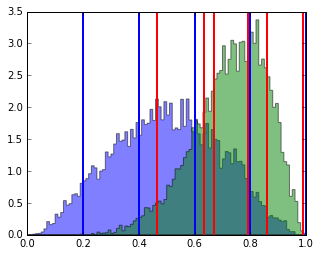

In [109]:
fig = plt.figure(figsize=(5,4))
plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5,normed=True)
plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5,normed=True)
for b in np.sort(results.x):
    plt.axvline(x=b, linewidth=2.0, color='red')
for b in np.sort(np.linspace (0,1,ncat+1)):
    plt.axvline(x=b, linewidth=2.0, color='blue')
# plt.yscale('log')
plt.show()

In [110]:
results.x, results.fun

(array([ 0.6346,  0.7901,  0.6702,  0.4649,  0.9903,  0.8589]),
 -3.5154248833096933)

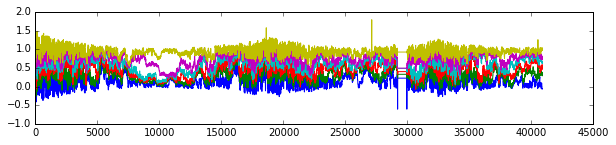

In [111]:
fig = plt.figure(figsize=(10,2))
for ix in range(results.x.shape[0]):
    plt.plot(range(np.array(binner.scan['bounds']).shape[0]), np.array(binner.scan['bounds'])[:,ix] )

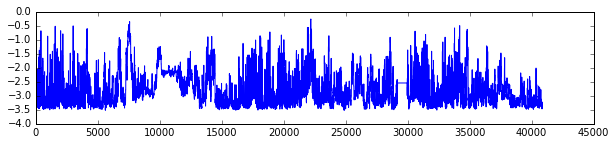

In [112]:
fig = plt.figure(figsize=(10,2))
plt.plot(range(np.array(binner.scan['bounds']).shape[0]), np.array(binner.scan['cost']))

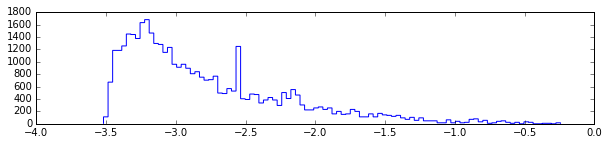

In [113]:
fig = plt.figure(figsize=(10,2))
plt.hist(np.array(binner.scan['cost']),bins=100,
         range=[min(np.array(binner.scan['cost'])),max(np.array(binner.scan['cost']))], 
         histtype='step')
plt.show()

In [114]:
np.sort(results.x)

array([ 0.4649,  0.6346,  0.6702,  0.7901,  0.8589,  0.9903])

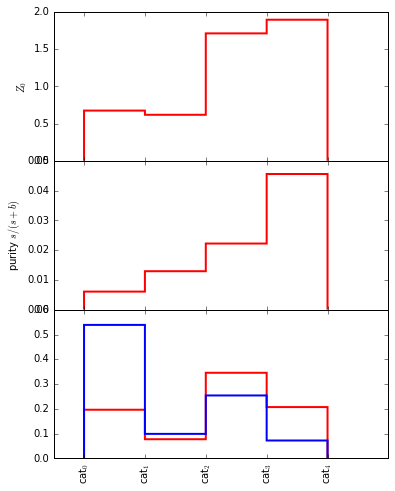

In [115]:
f = plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.001)

labels = ["cat$_{%i}$" % i for i in np.arange(binner.nbins)]
ax1 = plt.subplot(311)
ax1.hist(np.arange(binner.nbins)+0.5,bins= np.arange(binner.nbins),
         weights=binner.binned_score(np.sort(results.x)), 
         linewidth=2.0, color='red', histtype='step')
ax1.set_ylabel("$Z_0$")

ax2 = plt.subplot(312, sharex=ax1)
ws,_  = np.histogram(data[y==1],bins=np.sort(results.x), weights=weight[y==1])
wb,_  = np.histogram(data[y==0],bins=np.sort(results.x), weights=weight[y==0])
ax2.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=ws/(ws+wb), 
         linewidth=2.0, color='red', histtype='step')

ax2.set_ylabel("purity $s/(s+b)$")
ax3 = plt.subplot(313, sharex=ax2)
ax3.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=ws/ws.sum(), 
         linewidth=2.0, color='red', histtype='step')
ax3.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=wb/wb.sum(), 
         linewidth=2.0, color='blue', histtype='step')

xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xticks(np.arange(binner.nbins), labels, rotation='vertical')
ax1.set_xlim([-0.5, binner.nbins])
plt.show()

In [117]:
np.sqrt(-results.fun)

1.874946634789826

In [118]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)

z_cv = []
x_cv = []

for (train, test) in cv.split(data, y):
    binner_  = zbinner(3,[0,1])
    result_  = binner_.fit(data[train], y[train], sample_weights = weight[train])
    z_cv.append(result_.fun)
    x_cv.append(result_.x)
    
print x_cv
print z_cv

[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[1 1 1 1] [0 0 0 0]
[array([ 0.9863,  0.7995,  0.5885,  0.8567]), array([ 0.8093,  0.6667,  0.5214,  0.9904]), array([ 0.6541,  0.4535,  0.7999,  0.9847]), array([ 0.5043,  0.6748,  0.9867,  0.8171]), array([ 0.802 ,  0.705 ,  0.569 ,  0.9888]), array([ 0.6948,  0.9996,  0.8058,  0.5044]), array([ 0.9424,  0.7978,  0.9762,  0.5975]), array([ 0.9978,  0.8396,  0.574 ,  0.718 ]), array([ 0.8093,  0.6667,  0.5214,  0.9904]), array([ 0.9863,  0.7995,  0.5885,  0.8567])]
[-3.2737539887686005, -3.2686849862644332, -3.2566863734781948, -3.3212757160803039, -3.2572627081871266, -3.2808784835852398, -3.3122377295197798, -3.2903310528598908, -3.2906976254041393, -3.2236306119595004]


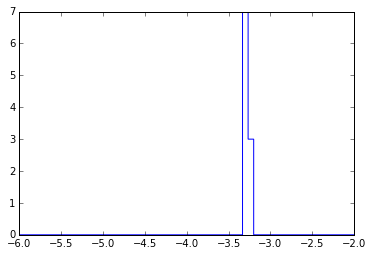

In [119]:
plt.hist(z_cv,bins=60,
         range=[-6,-2], 
         histtype='step')
plt.show()

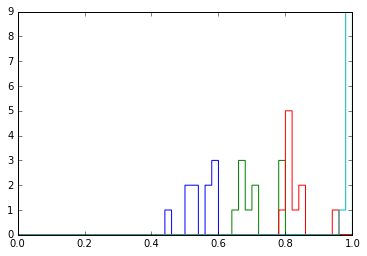

In [120]:
xx_ = np.sort(np.array(x_cv))
for i in range(4):
    plt.hist(xx_.T[i],bins=50,
             range=[0,1], 
             histtype='step')
plt.show()

In [121]:
from scipy import stats as st
cov = np.zeros((xx_.shape[1],xx_.shape[1]))
for i in range(xx_.shape[1]):
    for j in range(xx_.shape[1]):
        cov[i][j] = st.pearsonr(xx_.T[i], xx_.T[j])[0]

In [122]:
cov

array([[ 1.    ,  0.8583,  0.6963, -0.2336],
       [ 0.8583,  1.    ,  0.8067, -0.4159],
       [ 0.6963,  0.8067,  1.    , -0.6257],
       [-0.2336, -0.4159, -0.6257,  1.    ]])

In [92]:
fig = plt.figure(figsize=(5,3))
z_cv = []
x_cv = []
for cat in np.arange(1,7):
    print " --- ", cat
    binner_  = zbinner(cat,[0,1])
    result_  = (binner_.fit(data[train], y[train], sample_weights = weight[train])
    z.append.fun)

SyntaxError: invalid syntax (<ipython-input-92-597106eb4a90>, line 8)

In [ ]:
z = np.array(z)
plt.plot(np.arange(1,7), np.sqrt(-z) )

In [ ]:
fig = plt.figure(figsize=(5,3))
x = np.arange(0,1, 0.001)
z = []
for ix in x :
    z.append(binner.cost_fun(np.array([ix,1]))  )
plt.plot(x,z)
for b in results.x:
    plt.axvline(x=b, linewidth=2.0, color='red')
    
plt.xlim([0,1])

In [ ]:
fig = plt.figure(figsize=(5,3))
bb = np.array(binner.scan['bounds'])
b0 = bb[:,0]
b1 = bb[:,1]
plt.hist(b1,bins=200,
         range=[0,1], 
         histtype='step')
plt.hist(b0,bins=200,
         range=[0,1], 
         histtype='step')
for b in results.x:
    plt.axvline(x=b, linewidth=2.0, color='red')

In [ ]:
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)

def _fun_(x,y):
    return binner.cost_fun(np.array([x,y,1]))
    
vec_fun_ = np.vectorize(_fun_)    

Z = vec_fun_(X,Y)

In [ ]:
print Z.min()
levels = np.arange(Z.min(),0.5*Z.min(), 0.2)
print b0.shape

In [ ]:
fig = plt.figure(figsize=(4,4))
levels = np.arange(Z.min(),0.85*Z.min(), 0.2)
plt.contour(X, Y, Z,levels, fontsize=9, inline=1)
plt.plot(results.x[0], results.x[1], 'ro')

plt.plot(b1[35106-100:35106],b0[35106-100:35106])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.gif', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
bounds = [0,1]
bound_max   = [ max(bounds) for i in range(5)]
bound_min   = [ min(bounds) for i in range(5)]
bound_max, bound_min